# GANS/Cyclic GANS For Data Augmentation and Neural Style Transfer

In [278]:
import tensorflow as tf
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import shutil
import random
import itertools
import math
import time
import wandb

from skimage.io import imread
from skimage.transform import resize
from mpl_toolkits.axes_grid1 import ImageGrid

# Model class
from tensorflow.keras.models import Model, Sequential

# Layers
from tensorflow.keras.layers import (LeakyReLU, BatchNormalization, Dropout, 
                                     Flatten, Conv2D, Dense, MaxPool2D, Conv2DTranspose, 
                                     GlobalMaxPool2D, Reshape, BatchNormalization, Input, Embedding, multiply)
from tensorflow.keras.layers import Layer
from tensorflow.keras import layers

# Optimizer
from tensorflow.keras.optimizers import Adam

# Loss function
from tensorflow.keras.losses import BinaryCrossentropy

# Data loader
from tensorflow.keras.utils import Sequence

# Metrics
from tensorflow.keras.metrics import BinaryAccuracy, Recall, Precision, MSE

# ImageLoader
from skimage.io import imread

# Weights Initializer
from tensorflow.keras.initializers import RandomNormal, GlorotNormal, GlorotUniform

# Callbacks
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

In [136]:
# To limit GPU VRAM allocation by tensorflow
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

## Pre-Processing The Data

In [42]:
class DataLoader(Sequence):
    
    def __init__(self, im_dir, labels= None, batch_size= 32, output_dim= None, classification= True, shuffle= True):
        
        self.im_dir = im_dir
        self.classification = classification
        self.shuffle = shuffle
        self.resize = resize
        self.output_dim = output_dim
        
        self.labels = {}
        if isinstance(labels, list):
            for i, label in enumerate(labels):
                self.labels[label] = i
        elif isinstance(labels, dict):
            self.labels = labels
        else:
            for root_dir, subdirs, files in os.walk(self.im_dir):
                for i, subdir in enumerate(subdirs):
                    self.labels[subdir] = i
        
            
        self.images = glob.glob(f"{self.im_dir}/*/*")
        random.shuffle(self.images)
        self.batch_size = len(self.images) if batch_size == -1 else batch_size
        
        self.on_epoch_end()
        
    
    def __len__(self):
        return int(np.floor(len(self.images)/self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        im_files_batch = [self.images[idx] for idx in indexes]
        if self.output_dim:
            batch_images = np.array([resize(imread(file), self.output_dim, preserve_range= True) for file in im_files_batch], dtype= np.uint8)
            
        else:
            batch_images = np.arrary([imread(file) for file in im_files_batch], dtype= np.uint8)
        
        if self.classification:
            batch_images = np.asanyarray(batch_images, dtype= np.float32)/255.
        else:
            batch_images = (np.asanyarray(batch_images, dtype= np.float32) - 127.5)/127.5
            
        batch_labels = np.empty((self.batch_size), dtype= np.uint8)
        for i, im in enumerate(im_files_batch):
            for label in self.labels.keys():
                if label in im:
                    batch_labels[i] = self.labels[label]
        return batch_images, batch_labels.reshape(-1, 1)
    
    def on_epoch_end(self):
        "Updates all indexes after the end of each epoch"
        self.indexes = np.arange(len(self.images))
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
        
    def get_all_data(self, batched_data):
        return

In [83]:
train_horses_cows = DataLoader(im_dir= "dataset/Newdata/Train", classification= True, output_dim= (128, 128, 3), batch_size= 16)
val_horses_cows = DataLoader(im_dir= "dataset/Newdata/Test", classification= True, output_dim= (128, 128, 3))

In [84]:
# Get a batch of data
horses_cows_iter = iter(train_horses_cows)
batch_data = next(horses_cows_iter)

In [85]:
horse_batch = [data for i, data in enumerate(batch_data[0]) if batch_data[1][i] == 1]
cow_batch = [data for i, data in enumerate(batch_data[0]) if batch_data[1][i] == 0]

In [86]:
random_horse = np.random.choice(range(len(horse_batch)), size= 4, replace= False)
random_cow = np.random.choice(range(len(cow_batch)-1), size= 4, replace= False)
random_horse, random_cow

(array([1, 3, 6, 0]), array([3, 0, 4, 6]))

In [87]:
cow_images, horse_images = [cow_batch[i] for i in random_cow], [horse_batch[i] for i in random_horse]

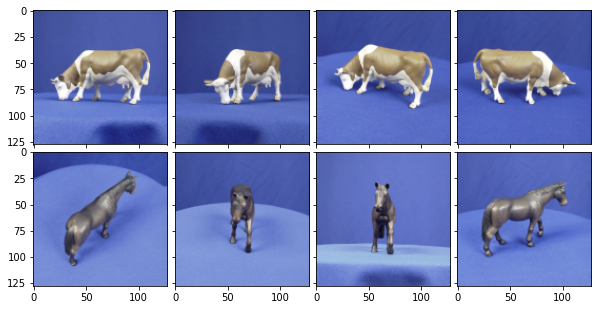

In [88]:
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [*cow_images, *horse_images]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

## Define Metrics For Classification
- Accuracy
- Precision
- Recall

In [89]:
def show_metrics_classification(model_history):
    metrics = ["_".join(metric.split("_")[1:]) for metric in model_history.history.keys() if "val" not in metric]
    print(metrics)
    colors = list(itertools.combinations(['b', 'g', 'r', 'c', 'm', 'y', 'k'], 2))
    
    f = plt.figure()
    f.set_figwidth(2.5*len(metrics))
    f.set_figheight(3*len(metrics))
    for i, metric in enumerate(metrics):
        plt.subplot(math.ceil(len(metrics)/2), 2, i+1)
        color_plts = np.random.randint(0, len(colors))
        plt.plot(model_history.history[f"train_{metric}"], color= colors[color_plts][0])
        plt.plot(model_history.history[f"val_{metric}"], color= colors[color_plts][1])
        plt.ylabel(metric)
        plt.xlabel("epochs")
        plt.legend(["train", "val"], loc= "upper left")
        plt.title(f"{metric.title()} vs Epochs")
    plt.show()
    

## Building The Classifier

In [90]:
class Classifier(Model):
    
    def __init__(self, name):
        super(Classifier, self).__init__(name= name)
        
    def build(self, input_shape):
        
        self.conv1 = Conv2D(filters= 50, kernel_size= 3, activation= 'relu', padding= 'same', kernel_initializer= 'glorot_uniform', input_shape= input_shape)
        self.maxpool1 = MaxPool2D(pool_size= (2, 2))
        
        self.conv2 = Conv2D(filters= 20, kernel_size= 3, activation= 'relu', padding= 'valid', kernel_initializer= 'glorot_uniform')
        self.maxpool2 = MaxPool2D(pool_size= (2, 2))
        
        self.conv3 = Conv2D(filters= 5, kernel_size= 3, activation= 'relu', padding= 'valid', kernel_initializer= 'glorot_uniform')
        self.maxpool3 = MaxPool2D(pool_size= (2, 2))
        
        self.flatten = Flatten()
        self.dense1 = Dense(units= 30, activation= 'relu', kernel_initializer= 'glorot_uniform')
        self.dense2 = Dense(units= 20, activation= 'relu', kernel_initializer= 'glorot_uniform')
        self.dense3 = Dense(units= 1, activation= 'sigmoid', kernel_initializer= 'glorot_uniform')
        
        super(Classifier, self).build(input_shape)
    
    def call(self, input_):
        x = self.conv1(input_)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.maxpool2(x)
        
        x = self.conv3(x)
        x = self.maxpool3(x)
     
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        
        output = self.dense3(x)
        return output
    
    def train_step(self, train_batch):
        X_train, y_train = train_batch
        
        with tf.GradientTape() as tape:
            # apply forward pass
            y_pred = self(X_train, training= True)
            loss = self.compiled_loss(y_train, y_pred, regularization_losses= self.losses)
        # calculate gradients - uses reverse gradient autodiff
        gradients = tape.gradient(loss, self.trainable_variables)
        # backpropagate the gradients and update the weights using the compiled optimizer
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        self.compiled_metrics.update_state(y_train, y_pred)
        return {f"train_{metric.name}": metric.result() for metric in self.metrics}
    
    def test_step(self, test_batch):
        X_test, y_test = test_batch
        # obtain prediciton
        y_pred = self(X_test, training= False)
        
        # updates loss metric
        self.compiled_loss(y_test, y_pred)
        
        # updates metrics
        self.compiled_metrics.update_state(y_test, y_pred)
        
        return {f"{metric.name}": metric.result() for metric in self.metrics}

## Traning the Classifier

In [91]:
EPOCHS= 50
BATCH_SIZE= 16
IMAGE_SIZE= (128, 128, 3)

In [94]:
train_horses_cows_classification = DataLoader(im_dir= "dataset/Newdata/Train", classification= True, output_dim= IMAGE_SIZE, batch_size= BATCH_SIZE)
val_horses_cows_classification = DataLoader(im_dir= "dataset/Newdata/Test", classification= True, output_dim= IMAGE_SIZE, batch_size= BATCH_SIZE)

In [96]:
horses_cows_classifier = Classifier(name= "Horses_vs_Cows_Classifier")
horses_cows_classifier.build(input_shape= (None, *IMAGE_SIZE))

horses_cows_classifier.summary()
horses_cows_classifier.compile(optimizer= Adam(0.001), loss= BinaryCrossentropy(), metrics= [BinaryAccuracy(), Recall(), Precision(), MSE])
model_data = horses_cows_classifier.fit(train_horses_cows_classification, validation_data= val_horses_cows_classification, epochs= EPOCHS, workers= 10)

Model: "Horses_vs_Cows_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            multiple                  1400      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_10 (Conv2D)           multiple                  9020      
_________________________________________________________________
max_pooling2d_10 (MaxPooling multiple                  0         
_________________________________________________________________
conv2d_11 (Conv2D)           multiple                  905       
_________________________________________________________________
max_pooling2d_11 (MaxPooling multiple                  0         
_________________________________________________________________
flatten_3 (Flatten)          multiple    

5/5 [==============================] - 1s 110ms/step - train_loss: 7.5360e-05 - train_binary_accuracy: 1.0000 - train_recall_3: 1.0000 - train_precision_3: 1.0000 - train_mean_squared_error: 3.1029e-08 - val_loss: 3.9241 - val_binary_accuracy: 0.5500 - val_recall_3: 0.1750 - val_precision_3: 0.7000 - val_mean_squared_error: 0.4226
Epoch 21/50
5/5 [==============================] - 1s 106ms/step - train_loss: 5.2287e-05 - train_binary_accuracy: 1.0000 - train_recall_3: 1.0000 - train_precision_3: 1.0000 - train_mean_squared_error: 1.2173e-08 - val_loss: 4.0101 - val_binary_accuracy: 0.5500 - val_recall_3: 0.1750 - val_precision_3: 0.7000 - val_mean_squared_error: 0.4212
Epoch 22/50
5/5 [==============================] - 1s 124ms/step - train_loss: 5.1950e-05 - train_binary_accuracy: 1.0000 - train_recall_3: 1.0000 - train_precision_3: 1.0000 - train_mean_squared_error: 1.6903e-08 - val_loss: 4.0489 - val_binary_accuracy: 0.5500 - val_recall_3: 0.1750 - val_precision_3: 0.7000 - val_mean

Epoch 44/50
5/5 [==============================] - 1s 126ms/step - train_loss: 3.3191e-05 - train_binary_accuracy: 1.0000 - train_recall_3: 1.0000 - train_precision_3: 1.0000 - train_mean_squared_error: 6.4378e-09 - val_loss: 4.0441 - val_binary_accuracy: 0.5625 - val_recall_3: 0.1795 - val_precision_3: 0.7000 - val_mean_squared_error: 0.4165
Epoch 45/50
5/5 [==============================] - 1s 125ms/step - train_loss: 3.6538e-05 - train_binary_accuracy: 1.0000 - train_recall_3: 1.0000 - train_precision_3: 1.0000 - train_mean_squared_error: 8.8596e-09 - val_loss: 4.1295 - val_binary_accuracy: 0.5625 - val_recall_3: 0.2000 - val_precision_3: 0.7273 - val_mean_squared_error: 0.4168
Epoch 46/50
5/5 [==============================] - 1s 107ms/step - train_loss: 3.3053e-05 - train_binary_accuracy: 1.0000 - train_recall_3: 1.0000 - train_precision_3: 1.0000 - train_mean_squared_error: 6.8119e-09 - val_loss: 4.1124 - val_binary_accuracy: 0.5625 - val_recall_3: 0.2000 - val_precision_3: 0.727

['loss', 'binary_accuracy', 'recall_3', 'precision_3', 'mean_squared_error']


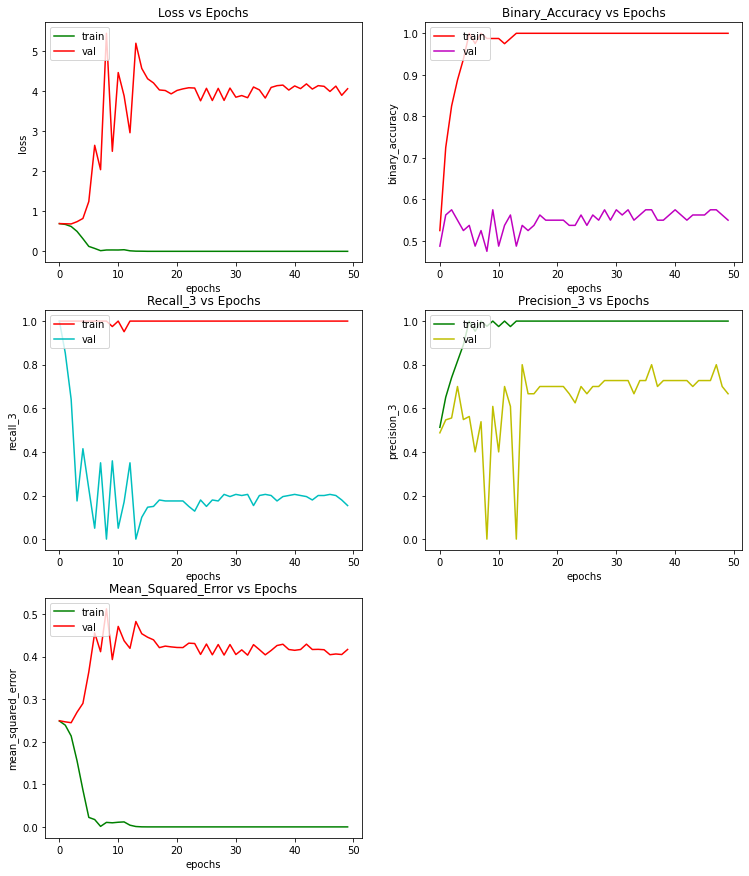

In [100]:
show_metrics_classification(horses_cows_classifier.history)

## DC-GAN
First, we will experiment with a normal DCGAN without conditioning the output to a desired target variable. This way we gain more understanding of how GANs train which can be carried to the Conditional GAN part.

### Building The DCGAN Architecture
#### Generator
#### Convolutional Layer With Batch Normalization and Leaky ReLU Activation Function
This block will be used multiple times in the Generator Block

In [101]:
class Conv2DTBatchNorm(Layer):
    def __init__(self, filters, kernel_size, strides, padding, use_bias):
        super(Conv2DTBatchNorm, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.use_bias = use_bias
    
    def build(self, input_shape):
        self.conv2d_t = Conv2DTranspose(filters= self.filters, kernel_size= self.kernel_size, strides= self.strides, use_bias= self.use_bias)
        self.batch_norm = BatchNormalization()
        self.leaky_relu = LeakyReLU()
        super(Conv2DTBatchNorm, self).build(input_shape)
    
    def call(self, input_tensor):
        x = input_tensor
        
        x = self.conv2d_t(x)
        x = self.batch_norm(x)
        x = self.leaky_relu(x)
        
        return x    

In [102]:
class Generator(Model):
    def __init__(self, latent_dim, name, **kwargs):
        super(Generator, self).__init__(name= name, **kwargs)
        self.latent_dim = latent_dim
    
    def build(self, input_shape):
        assert input_shape[1:] == (1, 1, self.latent_dim), f"input_shape should have shape (batch_size, 1, 1, latent_dimension), received: {input_shape}"
        self.conv2d_t_1 = Conv2DTBatchNorm(filters= 64*12, kernel_size= (4, 4), strides=(1, 1), padding="valid", use_bias= False)
        self.conv2d_t_2 = Conv2DTBatchNorm(filters= 64*8, kernel_size= (2, 2), strides=(2, 2), padding="same", use_bias= False)
        self.conv2d_t_3 = Conv2DTBatchNorm(filters= 64*8, kernel_size= (2, 2), strides=(2, 2), padding="same", use_bias= False)
        self.conv2d_t_4 = Conv2DTBatchNorm(filters= 64*4, kernel_size= (2, 2), strides=(2, 2), padding="same", use_bias= False)
        self.conv2d_t_5 = Conv2DTBatchNorm(filters= 64*4, kernel_size= (2, 2), strides=(2, 2), padding="same", use_bias= False)
        self.conv2d_t_6 = Conv2DTBatchNorm(filters= 64*2, kernel_size= (2, 2), strides=(2, 2), padding="same", use_bias= False)
        
        self.conv2d = Conv2D(filters= 3, kernel_size= (3, 3), strides=(1, 1), padding="same", use_bias= False, activation= "tanh")
        super(Generator, self).build(input_shape)
    
    def call(self, input_tensor):
        x = input_tensor
        x = self.conv2d_t_1(x)
        x = self.conv2d_t_2(x)
        x = self.conv2d_t_3(x)
        x = self.conv2d_t_4(x)
        x = self.conv2d_t_5(x)
        x = self.conv2d_t_6(x)
        
        x = self.conv2d(x)
        return x

#### Discriminator

In [103]:
class Conv2DBatchNorm(Layer):
    def __init__(self, filters, kernel_size, strides, padding, use_bias, batch_norm= True):
        super(Conv2DBatchNorm, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.use_bias = use_bias
        self.batch_norm = batch_norm
        
    def build(self, input_shape):
        self.conv = Conv2D(filters= self.filters, kernel_size= self.kernel_size, strides= self.strides, padding= self.padding, use_bias= self.use_bias)
        if self.batch_norm:
            self.bn = BatchNormalization()
        self.leaky_relu = LeakyReLU(alpha= 0.2)
        
        super(Conv2DBatchNorm, self).build(input_shape)
    
    def call(self, input_tensor):
        x = input_tensor
        x = self.conv(x)
        if self.batch_norm:
            x = self.bn(x)
        x = self.leaky_relu(x)
        
        return x

In [104]:
class Discriminator(Model):
    def __init__(self, name, **kwargs):
        super(Discriminator, self).__init__(name, **kwargs)
    
    def build(self, input_shape):
        self.conv1 = Conv2DBatchNorm(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same", use_bias=False, batch_norm= False)
        
        self.conv_bn_1 = Conv2DBatchNorm(filters=64*2, kernel_size=(4, 4), strides=(2, 2), padding="same", use_bias=False, batch_norm= False)
        self.conv_bn_2 = Conv2DBatchNorm(filters=64*4, kernel_size=(4, 4), strides=(2, 2), padding="same", use_bias=False, batch_norm= False)        
        self.conv_bn_3 = Conv2DBatchNorm(filters=64*8, kernel_size=(4, 4), strides=(2, 2), padding="same", use_bias=False, batch_norm= False)        
        self.conv_bn_4 = Conv2DBatchNorm(filters=64*8, kernel_size=(4, 4), strides=(2, 2), padding="same", use_bias=False, batch_norm= False)        
        self.conv_bn_5 = Conv2DBatchNorm(filters=64*4, kernel_size=(4, 4), strides=(2, 2), padding="same", use_bias=False, batch_norm= False)        
        self.conv_bn_6 = Conv2DBatchNorm(filters=64*2, kernel_size=(4, 4), strides=(2, 2), padding="same", use_bias=False, batch_norm= False)
        self.conv_bn_7 = Conv2DBatchNorm(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same", use_bias=False, batch_norm= False)  
        
        self.conv2 = Conv2D(1, (3, 3), strides=(4, 4), padding="same", use_bias= False, activation= 'sigmoid')
        super(Discriminator, self).build(input_shape)
    
    def call(self, input_tensor):
        x = input_tensor
        x = self.conv1(x)
        
        x = self.conv_bn_1(x)
        x = self.conv_bn_2(x)
        x = self.conv_bn_3(x)
        x = self.conv_bn_4(x)
        x = self.conv_bn_5(x)        
        x = self.conv_bn_6(x)
        x = self.conv_bn_7(x)
        
        x = self.conv2(x)
        return x

#### GAN

In [106]:
class GAN(Model):
    def __init__(self, discriminator, generator, latent_dim, batch_size):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        
    def call(self, data, training=False): 
        # Method needed to be implemented for tensorflow reasons when using a custom data loader
        pass
    
    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # Sample random points in the latent space
        batch_size = self.batch_size
        #random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_latent_vectors = tf.random.normal(shape=(batch_size, 1, 1, self.latent_dim))
        
        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)
        
        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        
        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1, 1, 1)), tf.zeros((batch_size, 1, 1, 1))], axis=0
        )
        
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        #random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_latent_vectors = tf.random.normal(shape=(batch_size, 1, 1, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1, 1, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}

**Callbacks**

In [116]:
import datetime
class SaveImagesCallback(Callback):
    def __init__(self, logdir, latent_dim, save_freq, batch_size):
        self.logdir = Path(f"{logdir}/gan_image_output/{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}")
        self.latent_dim = latent_dim
        self.save_freq = save_freq
        
        self.logdir.mkdir(exist_ok=True, parents=True)
        self.batch_size = batch_size
        
        self.fixed_noise = tf.random.normal([self.batch_size, 1, 1, self.latent_dim])
        
    def on_epoch_end(self, epoch, logs= None):
        if epoch % self.save_freq == 0:
            generator = self.model.generator
            predictions = generator(self.fixed_noise, training=False)
            
            pred_index = np.random.choice(np.array(list(range(predictions.shape[0]))), size= predictions.shape[0])
            predictions = np.array([predictions[x, :, :, :] for x in pred_index])
            plt_shape = int(np.math.sqrt(predictions.shape[0]))
            
            fig = plt.figure(figsize=(8, 8))
            for i in range(predictions.shape[0]):
                plt.subplot(plt_shape, plt_shape, i+1)
                plt.imshow(np.asarray(predictions[i, :, :, :] * 127.5 + 127.5, dtype= np.uint8))
                plt.axis('off')
            plt.show()
            plt.savefig(f'{str(self.logdir)}/tf_image_at_epoch_{epoch:04d}.png')

In [132]:
BATCH_SIZE = 16
EPOCHS= 30000
EPOCH_SAVE_FREQ = 30000
LATENT_DIMENSION = 128
IMAGE_SIZE = (128, 128, 3)

In [133]:
train_horses_cows_data = DataLoader(im_dir= "dataset/Newdata/Train", classification= False, output_dim= IMAGE_SIZE, batch_size= BATCH_SIZE)

In [134]:
logdir = 'gan-logdir/horses_cows/'
isaveimg = SaveImagesCallback(logdir= logdir, latent_dim= LATENT_DIMENSION, save_freq= 100, batch_size= BATCH_SIZE)

Epoch 1/30000
5/5 [==============================] - ETA: 0s - d_loss: 0.6906 - g_loss: 0.6931

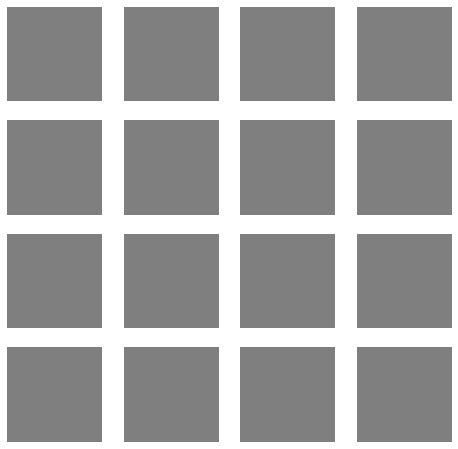

5/5 [==============================] - 1s 183ms/step - d_loss: 0.6898 - g_loss: 0.6930
Epoch 2/30000
5/5 [==============================] - 0s 94ms/step - d_loss: 0.5443 - g_loss: 0.6617
Epoch 3/30000
5/5 [==============================] - 0s 93ms/step - d_loss: 0.4758 - g_loss: 0.6138
Epoch 4/30000
5/5 [==============================] - 0s 94ms/step - d_loss: 0.5617 - g_loss: 0.5632
Epoch 5/30000
5/5 [==============================] - 0s 93ms/step - d_loss: 0.5847 - g_loss: 0.6334
Epoch 6/30000
5/5 [==============================] - 0s 93ms/step - d_loss: 0.4782 - g_loss: 0.8034
Epoch 7/30000
5/5 [==============================] - 0s 94ms/step - d_loss: 0.3936 - g_loss: 1.2320
Epoch 8/30000
5/5 [==============================] - 0s 93ms/step - d_loss: 0.5745 - g_loss: 0.6436
Epoch 9/30000
5/5 [==============================] - 0s 92ms/step - d_loss: 0.5536 - g_loss: 0.6074
Epoch 10/30000
5/5 [==============================] - 0s 95ms/step - d_loss: 0.4838 - g_loss: 0.6578
Epoch 11/300

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [135]:
discriminator = Discriminator(name= "Discriminator")
generator = Generator(latent_dim= LATENT_DIMENSION, name= "Generator")
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIMENSION, batch_size= BATCH_SIZE)

optimizer_d = Adam(0.0001, 0.5)
optimizer_g = Adam(0.0001, 0.5)

gan.compile(d_optimizer= optimizer_d, g_optimizer= optimizer_g, loss_fn=BinaryCrossentropy())
gan.fit(train_horses_cows_data, epochs=EPOCHS, callbacks= [isaveimg])

## Conditional GAN

In [212]:
tf.config.experimental_run_functions_eagerly(True)

In [232]:
class Generator(Model):
    def __init__(self, latent_dim, num_classes):
        super(Generator, self).__init__()
        self.latent_dim, self.num_classes = latent_dim, num_classes
        
    def build(self, input_shape):
        self.seq_model = Sequential(
            [
                Dense(16 * 16 * (self.latent_dim + self.num_classes)),
                LeakyReLU(alpha=0.2),
                Reshape((16, 16, (self.latent_dim + self.num_classes))),
                Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
                LeakyReLU(alpha=0.2),
                Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
                LeakyReLU(alpha=0.2),
                Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
                LeakyReLU(alpha=0.2),
                Conv2D(3, (7, 7), padding="same", activation="tanh"),    
            ]
        )
        super(Generator, self).build(input_shape)
        
    def call(self, input_tensor):
        noise, label = input_tensor
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))
        model_input = multiply([noise, label_embedding])
        
        output = self.seq_model(model_input)
        return output

In [271]:
def build_generator(latent_dim, num_classes):

    model = Sequential(
    [
        layers.InputLayer(latent_dim,),
        Dense(16 * 16 * (latent_dim + num_classes)),
        LeakyReLU(alpha=0.2),
        Reshape((16, 16, (latent_dim + num_classes))),
        Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        LeakyReLU(alpha=0.2),
        Conv2D(3, (7, 7), padding="same", activation="tanh"),
    ],
    name="generator",
    )

    model.summary()

    noise = Input(shape=(latent_dim,))
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Flatten()(Embedding(num_classes, latent_dim)(label))
    model_input = multiply([noise, label_embedding])
    img = model(model_input)

    return Model([noise, label], img)

In [272]:
class Discriminator(Model):
    def __init__(self, image_size, num_classes):
        super(Discriminator, self).__init__()
        self.img_shape, self.num_classes = image_size, num_classes
        
    def build(self, input_shape):
        self.seq_model = Sequential(
            [
                Dense(512),
                LeakyReLU(alpha=0.2),
                Dense(512),
                LeakyReLU(alpha=0.2),
                Dropout(0.4),
                Dense(512),
                LeakyReLU(alpha=0.2),
                Dropout(0.4),
                Dense(1, activation='sigmoid')
            ]
        )
        super(Discriminator, self).build(input_shape)
        
    def call(self, input_tensor):
        img, label = input_tensor
        assert img.shape[1:] == self.img_shape, f"Received input shape: {img.shape[1:]} does not match image shape: {self.img_shape} in Discriminator Call"
        
        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        flat_img = Flatten()(img)
        model_input = multiply([flat_img, label_embedding])
        
        output = self.seq_model(model_input)
        return output

In [273]:
def build_discriminator(img_shape, num_classes):

    model = Sequential()

    model.add(Dense(512, input_dim=np.prod(img_shape)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    label = Input(shape=(1,), dtype='int32')

    label_embedding = Flatten()(Embedding(num_classes, np.prod(img_shape))(label))
    flat_img = Flatten()(img)

    model_input = multiply([flat_img, label_embedding])

    validity = model(model_input)

    return Model([img, label], validity)

In [284]:
class CondGAN():
    def __init__(self, image_size, num_classes, latent_dim, generator, discriminator):
        # Input shape
        self.img_rows, self.cols, self.channels = image_size
        self.img_shape = image_size
        self.num_classes = num_classes
        self.latent_dim = latent_dim

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = build_discriminator(self.img_shape, self.num_classes)
        
        #self.discriminator.build(input_shape= [(None, *self.img_shape), (None, 1,)])
        
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = build_generator(latent_dim= self.latent_dim, num_classes= self.num_classes)
        #self.generator.build(input_shape= [(None, self.latent_dim), (None, 1,)])

        # The generator takes noise and the target label as input
        # and generates the corresponding class of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid = self.discriminator([img, label])

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
            optimizer=optimizer)

    def train(self, epochs, dataset, batch_size=128, sample_interval=50):

        # Load iterator dataset assuming DataLoader with one batch (full data)
        X_train, y_train = next(iter(dataset))

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels = X_train[idx], y_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, labels])

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Condition on labels
            sampled_labels = np.random.randint(0, self.num_classes, batch_size).reshape(-1, 1)

            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 2, 4
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        sampled_labels = np.array([[0], [0], [0], [0], [1], [1], [1], [1]]).reshape(-1, 1)

        gen_imgs = self.generator.predict([noise, sampled_labels])

        # Rescale images 0 - 1
        gen_imgs = gen_imgs

        fig, axs = plt.subplots(r, c)
        for i in range(r):
            cnt= 0
            for j in range(c):
                cnt = 0
                axs[i, j].imshow(np.asarray(gen_imgs[cnt,:,:, :]* 127.5 + 127.5, dtype= np.uint8))
                if i == 0:
                    title = "Cow"
                else:
                    title = "Horse"
                axs[i, j].set_title(title)
                axs[i, j].axis('off')
                cnt += 1
        plt.show()
        plt.close()

In [285]:
IMAGE_SIZE = (128, 128, 3)
BATCH_SIZE = -1
LATENT_DIM = 100
NUM_CLASSES = 2

In [286]:
train_horses_cows = DataLoader(im_dir= "dataset/Newdata/Train", classification= False, output_dim= IMAGE_SIZE, batch_size= BATCH_SIZE)

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_107 (Dense)            (None, 512)               25166336  
_________________________________________________________________
leaky_re_lu_120 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dense_108 (Dense)            (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_121 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_109 (Dense)            (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_122 (LeakyReLU)  (None, 512)             

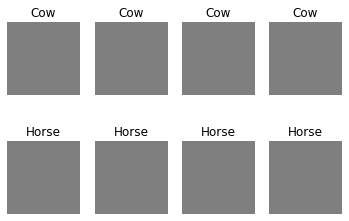

1 [D loss: 0.650677, acc.: 50.00%] [G loss: 0.691088]
2 [D loss: 0.570978, acc.: 50.00%] [G loss: 0.686391]
3 [D loss: 0.486570, acc.: 50.00%] [G loss: 0.674488]
4 [D loss: 0.434344, acc.: 50.00%] [G loss: 0.650729]
5 [D loss: 0.431886, acc.: 50.00%] [G loss: 0.604614]
6 [D loss: 0.477393, acc.: 50.00%] [G loss: 0.568566]
7 [D loss: 0.529527, acc.: 50.00%] [G loss: 0.542637]
8 [D loss: 0.557084, acc.: 50.00%] [G loss: 0.569074]
9 [D loss: 0.551250, acc.: 50.00%] [G loss: 0.667879]
10 [D loss: 0.498365, acc.: 56.25%] [G loss: 0.880991]
11 [D loss: 0.398560, acc.: 100.00%] [G loss: 1.238554]
12 [D loss: 0.444000, acc.: 100.00%] [G loss: 1.050677]
13 [D loss: 0.362659, acc.: 100.00%] [G loss: 0.976480]
14 [D loss: 0.433915, acc.: 68.75%] [G loss: 0.786403]
15 [D loss: 0.406893, acc.: 81.25%] [G loss: 0.782887]
16 [D loss: 0.370394, acc.: 75.00%] [G loss: 0.819780]
17 [D loss: 0.368619, acc.: 68.75%] [G loss: 0.842869]
18 [D loss: 0.307598, acc.: 81.25%] [G loss: 0.964316]
19 [D loss: 0.29

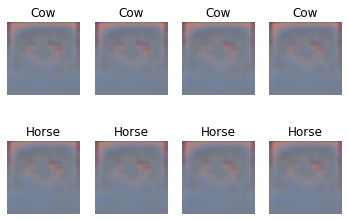

101 [D loss: 0.034178, acc.: 100.00%] [G loss: 3.693043]
102 [D loss: 0.110714, acc.: 100.00%] [G loss: 5.528047]
103 [D loss: 0.010278, acc.: 100.00%] [G loss: 6.377912]
104 [D loss: 0.075614, acc.: 93.75%] [G loss: 4.261579]
105 [D loss: 0.123813, acc.: 93.75%] [G loss: 5.264896]
106 [D loss: 0.007787, acc.: 100.00%] [G loss: 6.130332]
107 [D loss: 0.008073, acc.: 100.00%] [G loss: 4.763354]
108 [D loss: 0.005961, acc.: 100.00%] [G loss: 4.778715]
109 [D loss: 0.014623, acc.: 100.00%] [G loss: 4.194411]
110 [D loss: 0.021131, acc.: 100.00%] [G loss: 4.863897]
111 [D loss: 0.013488, acc.: 100.00%] [G loss: 4.472252]
112 [D loss: 0.010911, acc.: 100.00%] [G loss: 4.061883]
113 [D loss: 0.013236, acc.: 100.00%] [G loss: 4.550276]
114 [D loss: 0.031114, acc.: 100.00%] [G loss: 4.125167]
115 [D loss: 0.015058, acc.: 100.00%] [G loss: 3.939699]
116 [D loss: 0.024749, acc.: 100.00%] [G loss: 5.184779]
117 [D loss: 0.011016, acc.: 100.00%] [G loss: 4.580854]
118 [D loss: 0.153972, acc.: 93.7

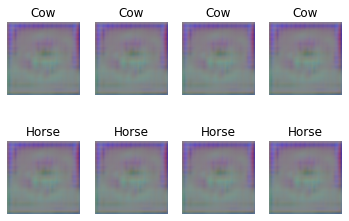

201 [D loss: 0.088860, acc.: 100.00%] [G loss: 5.095736]
202 [D loss: 0.087777, acc.: 93.75%] [G loss: 6.049382]
203 [D loss: 0.016334, acc.: 100.00%] [G loss: 6.236825]
204 [D loss: 0.001903, acc.: 100.00%] [G loss: 7.671834]
205 [D loss: 0.029545, acc.: 100.00%] [G loss: 5.443188]
206 [D loss: 0.187079, acc.: 75.00%] [G loss: 9.713498]
207 [D loss: 0.006016, acc.: 100.00%] [G loss: 10.081831]
208 [D loss: 0.168522, acc.: 93.75%] [G loss: 6.911649]
209 [D loss: 0.303901, acc.: 75.00%] [G loss: 7.787764]
210 [D loss: 0.012093, acc.: 100.00%] [G loss: 5.201914]
211 [D loss: 0.557449, acc.: 68.75%] [G loss: 8.623163]
212 [D loss: 0.042425, acc.: 100.00%] [G loss: 11.658331]
213 [D loss: 1.941972, acc.: 50.00%] [G loss: 9.672421]
214 [D loss: 0.777150, acc.: 68.75%] [G loss: 7.897833]
215 [D loss: 0.299702, acc.: 75.00%] [G loss: 10.042624]
216 [D loss: 0.118911, acc.: 100.00%] [G loss: 5.459185]
217 [D loss: 0.226471, acc.: 100.00%] [G loss: 10.262018]
218 [D loss: 0.272261, acc.: 100.00

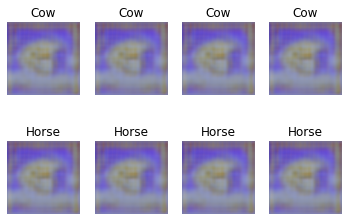

301 [D loss: 0.062969, acc.: 93.75%] [G loss: 7.111602]
302 [D loss: 0.256022, acc.: 93.75%] [G loss: 7.717104]
303 [D loss: 0.139187, acc.: 87.50%] [G loss: 8.538386]
304 [D loss: 0.125002, acc.: 93.75%] [G loss: 11.674591]
305 [D loss: 0.347167, acc.: 75.00%] [G loss: 10.557715]
306 [D loss: 0.060270, acc.: 100.00%] [G loss: 9.800562]
307 [D loss: 0.083945, acc.: 100.00%] [G loss: 6.666616]
308 [D loss: 0.400085, acc.: 75.00%] [G loss: 4.931171]
309 [D loss: 0.145223, acc.: 93.75%] [G loss: 9.732843]
310 [D loss: 0.051315, acc.: 100.00%] [G loss: 8.448235]
311 [D loss: 0.025194, acc.: 100.00%] [G loss: 6.170980]
312 [D loss: 0.150653, acc.: 93.75%] [G loss: 8.578733]
313 [D loss: 0.025180, acc.: 100.00%] [G loss: 8.350391]
314 [D loss: 0.207892, acc.: 93.75%] [G loss: 5.653658]
315 [D loss: 0.241360, acc.: 81.25%] [G loss: 5.516197]
316 [D loss: 0.202958, acc.: 93.75%] [G loss: 6.666809]
317 [D loss: 0.366131, acc.: 81.25%] [G loss: 10.091757]
318 [D loss: 0.103389, acc.: 93.75%] [G 

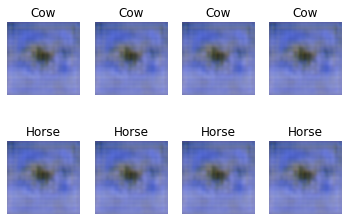

401 [D loss: 1.135643, acc.: 68.75%] [G loss: 10.184787]
402 [D loss: 0.305252, acc.: 81.25%] [G loss: 9.076594]
403 [D loss: 0.219276, acc.: 93.75%] [G loss: 8.761370]
404 [D loss: 0.105738, acc.: 93.75%] [G loss: 4.118827]
405 [D loss: 0.253471, acc.: 93.75%] [G loss: 8.411680]
406 [D loss: 0.116338, acc.: 100.00%] [G loss: 8.064016]
407 [D loss: 0.117474, acc.: 93.75%] [G loss: 8.623918]
408 [D loss: 0.078221, acc.: 100.00%] [G loss: 8.495469]
409 [D loss: 0.444973, acc.: 87.50%] [G loss: 9.225226]
410 [D loss: 0.286234, acc.: 81.25%] [G loss: 10.607904]
411 [D loss: 0.306410, acc.: 81.25%] [G loss: 5.580232]
412 [D loss: 0.175402, acc.: 93.75%] [G loss: 11.040735]
413 [D loss: 0.433058, acc.: 62.50%] [G loss: 8.959444]
414 [D loss: 0.204404, acc.: 93.75%] [G loss: 7.672292]
415 [D loss: 0.087915, acc.: 100.00%] [G loss: 6.578234]
416 [D loss: 0.495730, acc.: 75.00%] [G loss: 12.174070]
417 [D loss: 0.258745, acc.: 93.75%] [G loss: 11.882168]
418 [D loss: 0.462339, acc.: 75.00%] [G 

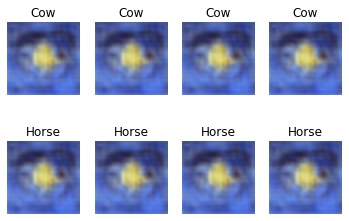

501 [D loss: 0.765711, acc.: 87.50%] [G loss: 4.025692]
502 [D loss: 0.156885, acc.: 93.75%] [G loss: 4.510087]
503 [D loss: 0.083057, acc.: 100.00%] [G loss: 5.435758]
504 [D loss: 0.185866, acc.: 93.75%] [G loss: 10.281734]
505 [D loss: 0.248491, acc.: 93.75%] [G loss: 7.096419]
506 [D loss: 0.243179, acc.: 87.50%] [G loss: 10.491982]
507 [D loss: 0.324887, acc.: 87.50%] [G loss: 5.934614]
508 [D loss: 0.071192, acc.: 100.00%] [G loss: 13.919927]
509 [D loss: 0.133625, acc.: 100.00%] [G loss: 8.141819]
510 [D loss: 0.053981, acc.: 100.00%] [G loss: 9.502584]
511 [D loss: 0.301687, acc.: 81.25%] [G loss: 12.494040]
512 [D loss: 0.060930, acc.: 100.00%] [G loss: 7.290298]
513 [D loss: 0.244071, acc.: 93.75%] [G loss: 4.009589]
514 [D loss: 0.268407, acc.: 87.50%] [G loss: 6.635071]
515 [D loss: 0.016610, acc.: 100.00%] [G loss: 13.759786]
516 [D loss: 0.487150, acc.: 87.50%] [G loss: 8.230361]
517 [D loss: 0.237613, acc.: 100.00%] [G loss: 4.794906]
518 [D loss: 0.200946, acc.: 87.50%]

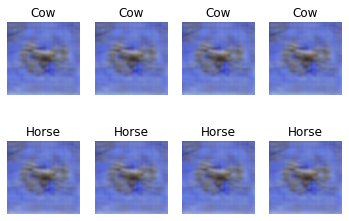

601 [D loss: 0.271456, acc.: 81.25%] [G loss: 7.281647]
602 [D loss: 0.406799, acc.: 81.25%] [G loss: 6.205238]
603 [D loss: 0.206873, acc.: 93.75%] [G loss: 11.251825]
604 [D loss: 0.224471, acc.: 93.75%] [G loss: 3.704946]
605 [D loss: 0.210573, acc.: 93.75%] [G loss: 7.550668]
606 [D loss: 0.255055, acc.: 87.50%] [G loss: 10.062643]
607 [D loss: 0.413575, acc.: 87.50%] [G loss: 4.423685]
608 [D loss: 0.503665, acc.: 81.25%] [G loss: 7.044109]
609 [D loss: 0.490348, acc.: 93.75%] [G loss: 4.807414]
610 [D loss: 0.021072, acc.: 100.00%] [G loss: 10.096808]
611 [D loss: 0.137772, acc.: 93.75%] [G loss: 4.405694]
612 [D loss: 0.682070, acc.: 62.50%] [G loss: 5.907455]
613 [D loss: 0.109955, acc.: 93.75%] [G loss: 9.558443]
614 [D loss: 0.082574, acc.: 93.75%] [G loss: 7.000531]
615 [D loss: 0.338196, acc.: 75.00%] [G loss: 6.700229]
616 [D loss: 0.153924, acc.: 93.75%] [G loss: 7.069528]
617 [D loss: 0.588896, acc.: 87.50%] [G loss: 7.300599]
618 [D loss: 0.377684, acc.: 87.50%] [G loss

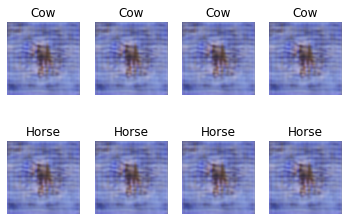

701 [D loss: 0.414021, acc.: 81.25%] [G loss: 8.061749]
702 [D loss: 0.324378, acc.: 87.50%] [G loss: 6.844711]
703 [D loss: 0.325381, acc.: 87.50%] [G loss: 7.906321]
704 [D loss: 0.522078, acc.: 62.50%] [G loss: 4.254880]
705 [D loss: 0.113880, acc.: 100.00%] [G loss: 5.671772]
706 [D loss: 0.268691, acc.: 87.50%] [G loss: 7.697620]
707 [D loss: 0.118049, acc.: 93.75%] [G loss: 7.268635]
708 [D loss: 0.439177, acc.: 75.00%] [G loss: 5.728842]
709 [D loss: 0.111628, acc.: 93.75%] [G loss: 8.651333]
710 [D loss: 0.220492, acc.: 93.75%] [G loss: 6.914055]
711 [D loss: 0.071974, acc.: 100.00%] [G loss: 4.755798]
712 [D loss: 0.126123, acc.: 93.75%] [G loss: 4.358371]
713 [D loss: 0.093649, acc.: 100.00%] [G loss: 9.487518]
714 [D loss: 0.167172, acc.: 93.75%] [G loss: 4.678440]
715 [D loss: 0.171623, acc.: 93.75%] [G loss: 7.401780]
716 [D loss: 0.113522, acc.: 93.75%] [G loss: 6.127358]
717 [D loss: 0.400262, acc.: 87.50%] [G loss: 6.482025]
718 [D loss: 0.157039, acc.: 93.75%] [G loss:

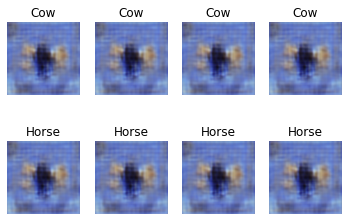

801 [D loss: 0.620740, acc.: 68.75%] [G loss: 4.527981]
802 [D loss: 0.076890, acc.: 100.00%] [G loss: 6.054659]
803 [D loss: 0.206821, acc.: 93.75%] [G loss: 9.649299]
804 [D loss: 0.216027, acc.: 93.75%] [G loss: 9.627172]


KeyboardInterrupt: 

In [287]:
generator = Generator(LATENT_DIM, NUM_CLASSES)
discriminator = Discriminator(IMAGE_SIZE, NUM_CLASSES)

cgan = CondGAN(image_size= IMAGE_SIZE, num_classes= NUM_CLASSES, latent_dim= LATENT_DIM, generator= generator, discriminator= discriminator)
cgan.train(epochs=40000, dataset= train_horses_cows, batch_size=8, sample_interval=100)

### Generating 1000 Images for Both Cows and Horses

In [301]:
nb_of_images = 500
noise = tf.random.normal(shape= (1000, 100))
labels = np.random.randint(low= 0, high= 2, size= (1000, 1)).reshape(-1, 1)

generated_cows_horses_images = np.asarray(cgan.generator.predict([noise, label]) * 127.5 + 127.5, dtype= np.uint8)

In [302]:
generated_data = (generated_cows_horses_images, labels)

In [303]:
horse_batch = [data for i, data in enumerate(generated_data[0]) if generated_data[1][i] == 1]
cow_batch = [data for i, data in enumerate(generated_data[0]) if generated_data[1][i] == 0]

In [304]:
random_horse = np.random.choice(range(len(horse_batch)), size= 4, replace= False)
random_cow = np.random.choice(range(len(cow_batch)-1), size= 4, replace= False)
random_horse, random_cow

(array([167,  87,  52, 117]), array([208, 393, 187,  83]))

In [305]:
cow_images, horse_images = [cow_batch[i] for i in random_cow], [horse_batch[i] for i in random_horse]

	Generated Data


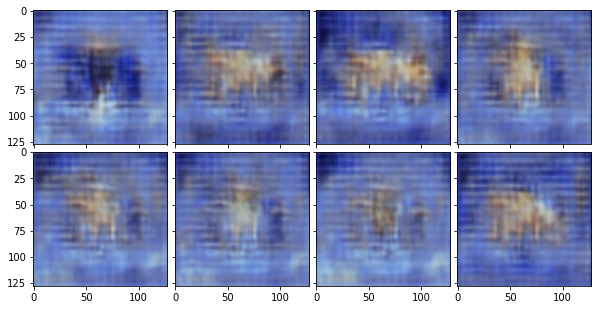

In [315]:
fig = plt.figure(figsize=(10., 10.), constrained_layout=True)
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [*cow_images, *horse_images]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
print("\tGenerated Data")
plt.show()

### Appending To Original Dataset

In [323]:
train_horses_cows_classification = DataLoader(im_dir= "dataset/Newdata/Train", classification= True, output_dim= IMAGE_SIZE, batch_size= BATCH_SIZE)
train_horses_cows_classification = tf.keras.preprocessing.

AttributeError: module 'tensorflow.keras.preprocessing' has no attribute 'image_dataset_from_directory'

'2.2.0'

In [318]:
EPOCHS= 50
BATCH_SIZE= 16
IMAGE_SIZE= (128, 128, 3)

In [ ]:
horses_cows_classifier = Classifier(name= "Horses_vs_Cows_Classifier")
horses_cows_classifier.build(input_shape= (None, *IMAGE_SIZE))

horses_cows_classifier_gen.summary()
horses_cows_classifier_gen.compile(optimizer= Adam(0.001), loss= BinaryCrossentropy(), metrics= [BinaryAccuracy(), Recall(), Precision(), MSE])
model_data = horses_cows_classifier_gen.fit(train_horses_cows_classification, validation_data= val_horses_cows_classification, epochs= EPOCHS, workers= 10)

In [ ]:
show_metrics_classification(horses_cows_classifier_gen)

### Classification Re-training

### Re-training Results

## Neural Style Transfer and Cycle GANs

In [ ]:
import scipy

from keras.datasets import mnist
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
from data_loader import DataLoader
import numpy as np
import os

class CycleGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # Configure data loader
        self.dataset_name = 'apple2orange'
        self.data_loader = DataLoader(dataset_name=self.dataset_name,
                                      img_res=(self.img_rows, self.img_cols))


        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 32
        self.df = 64

        # Loss weights
        self.lambda_cycle = 10.0                    # Cycle-consistency loss
        self.lambda_id = 0.1 * self.lambda_cycle    # Identity loss

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminators
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        self.d_A.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])
        self.d_B.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generators
        #-------------------------

        # Build the generators
        self.g_AB = self.build_generator()
        self.g_BA = self.build_generator()

        # Input images from both domains
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # Translate images to the other domain
        fake_B = self.g_AB(img_A)
        fake_A = self.g_BA(img_B)
        # Translate images back to original domain
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        # Identity mapping of images
        img_A_id = self.g_BA(img_A)
        img_B_id = self.g_AB(img_B)

        # For the combined model we will only train the generators
        self.d_A.trainable = False
        self.d_B.trainable = False

        # Discriminators determines validity of translated images
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        # Combined model trains generators to fool discriminators
        self.combined = Model(inputs=[img_A, img_B],
                              outputs=[ valid_A, valid_B,
                                        reconstr_A, reconstr_B,
                                        img_A_id, img_B_id ])
        self.combined.compile(loss=['mse', 'mse',
                                    'mae', 'mae',
                                    'mae', 'mae'],
                            loss_weights=[  1, 1,
                                            self.lambda_cycle, self.lambda_cycle,
                                            self.lambda_id, self.lambda_id ],
                            optimizer=optimizer)

    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            d = InstanceNormalization()(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = InstanceNormalization()(u)
            u = Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = Input(shape=self.img_shape)

        # Downsampling
        d1 = conv2d(d0, self.gf)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)

        # Upsampling
        u1 = deconv2d(d4, d3, self.gf*4)
        u2 = deconv2d(u1, d2, self.gf*2)
        u3 = deconv2d(u2, d1, self.gf)

        u4 = UpSampling2D(size=2)(u3)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u4)

        return Model(d0, output_img)

    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, normalization=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if normalization:
                d = InstanceNormalization()(d)
            return d

        img = Input(shape=self.img_shape)

        d1 = d_layer(img, self.df, normalization=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model(img, validity)

    def train(self, epochs, batch_size=1, sample_interval=50):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):

                # ----------------------
                #  Train Discriminators
                # ----------------------

                # Translate images to opposite domain
                fake_B = self.g_AB.predict(imgs_A)
                fake_A = self.g_BA.predict(imgs_B)

                # Train the discriminators (original images = real / translated = Fake)
                dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
                dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
                dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

                dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
                dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

                # Total disciminator loss
                d_loss = 0.5 * np.add(dA_loss, dB_loss)


                # ------------------
                #  Train Generators
                # ------------------

                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B],
                                                        [valid, valid,
                                                        imgs_A, imgs_B,
                                                        imgs_A, imgs_B])

                elapsed_time = datetime.datetime.now() - start_time

                # Plot the progress
                print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s " \
                                                                        % ( epoch, epochs,
                                                                            batch_i, self.data_loader.n_batches,
                                                                            d_loss[0], 100*d_loss[1],
                                                                            g_loss[0],
                                                                            np.mean(g_loss[1:3]),
                                                                            np.mean(g_loss[3:5]),
                                                                            np.mean(g_loss[5:6]),
                                                                            elapsed_time))

                # If at save interval => save generated image samples
                if batch_i % sample_interval == 0:
                    self.sample_images(epoch, batch_i)

    def sample_images(self, epoch, batch_i):
        os.makedirs('images/%s' % self.dataset_name, exist_ok=True)
        r, c = 2, 3

        imgs_A = self.data_loader.load_data(domain="A", batch_size=1, is_testing=True)
        imgs_B = self.data_loader.load_data(domain="B", batch_size=1, is_testing=True)

        # Demo (for GIF)
        #imgs_A = self.data_loader.load_img('datasets/apple2orange/testA/n07740461_1541.jpg')
        #imgs_B = self.data_loader.load_img('datasets/apple2orange/testB/n07749192_4241.jpg')

        # Translate images to the other domain
        fake_B = self.g_AB.predict(imgs_A)
        fake_A = self.g_BA.predict(imgs_B)
        # Translate back to original domain
        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)

        gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Original', 'Translated', 'Reconstructed']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[j])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%s/%d_%d.png" % (self.dataset_name, epoch, batch_i))
        plt.close()


if __name__ == '__main__':
    gan = CycleGAN()
    gan.train(epochs=200, batch_size=1, sample_interval=200)